<a href="https://colab.research.google.com/github/harveyvn/MNIST-Object-Localization/blob/master/MNIST_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motivation

In this notebook, I implemented a CNN from scratch to:
- classify the label in an image.
- localize it by drawing bounding boxes around it.

The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset is used to synthesize a custom dataset for the task:
- Place each `digit` image on a black background of width 75 x 75 at random locations.
- Calculate the corresponding bounding boxes for those `digits`.

The bounding box prediction can be modelled as a `regression` task, which means that the model will predict a numeric value.

# Download MNIST dataset

In [ ]:
import numpy as np
import tensorflow as tf

def get_ds_in_np(url):
    path = tf.keras.utils.get_file("dataset", url)
    with np.load(path) as data:
        train_samples = [x for x in data["x_train"]]
        train_labels = [x for x in data["y_train"]]
        test_samples = [x for x in data["x_test"]]
        test_labels = [x for x in data["y_test"]]
    return (train_samples, train_labels, test_samples, test_labels)

In [ ]:
(train_samples, train_labels, test_samples, test_labels) = get_ds_in_np("https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz")

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
def process_image(image):
    # Reshape image
    image = tf.reshape(image, (28,28,1))

    # Explaination:
    # We are expanding the image to 75 by 75 pixels by filling in the extra 
    # pixels (47 in x and 47 in y), 
    # and doing so in a random way so that the original is not always in the centre. 
    # This is where the 0, 48 comes from.

    # The generated values follow a uniform distribution in 
    # the range [minval, maxval). 
    # The lower bound minval is included in the range, while the upper bound 
    # maxval is excluded. That means we need 48 to get a max of 47
    x_min = tf.random.uniform((), 0, 48, dtype=tf.int32)
    y_min = tf.random.uniform((), 0, 48, dtype=tf.int32)
    image = tf.image.pad_to_bounding_box(image, y_min, x_min, 75, 75)

    # Normalization
    image = tf.cast(image, tf.float32).numpy()/255.0

    # TODO: need clarification
    x_min = tf.cast(x_min, tf.float32).numpy()
    y_min = tf.cast(y_min, tf.float32).numpy()
   
    x_max = (x_min + 28) / 75
    y_max = (y_min + 28) / 75
    x_min = x_min / 75
    y_min = y_min / 75
    return image, (x_min, y_min, x_max, y_max)


# Visualization

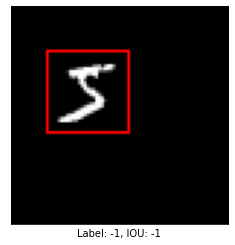

In [ ]:
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw

(image, bounding_box) = process_image(train_samples[0])

def show_image(image, label=-1, iou=-1, normalization=True, bb_color="red"):
    # Draw a digit
    # remove channel dimension, before reshape (75, 75, 1)
    image = image.reshape(75, 75)
    image = image * 255 if normalization else image
    image = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new("RGBA", image.size)
    rgbimg.paste(image)

    # Draw bounding box
    draw = PIL.ImageDraw.Draw(rgbimg)
    (x_min, y_min, x_max, y_max) = bounding_box
    im_width, im_height = rgbimg.size
    if normalization:
        (left, right, top, bottom) = (x_min * im_width, x_max * im_width,
                                    y_min * im_height, y_max * im_height)
    else:
        (left, right, top, bottom) = (x_min, x_max, y_min, y_max)
    draw.line([(left, top), (left, bottom), (right, bottom),
                (right, top), (left, top)], width=1, fill=bb_color)
    
    # Visualize an image
    plt.xlabel(f'Label: {label}, IOU: {iou}')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(rgbimg)

# Usage
show_image(image)

# Define the Network

Here, we define our custom CNN. 
- `feature_extractor`: these convolutional layers extract the features of the image.
- `classifier`:  This define the output layer that predicts among 10 categories (digits 0 through 9)
- `bounding_box_regression`: This defines the output layer that predicts 4 numeric values, which define the coordinates of the bounding box (xmin, ymin, xmax, ymax)
- `final_model`: This combines the layers for feature extraction, classification and bounding box prediction.  
  - Notice that this is another example of a branching model, because the model splits to produce two kinds of output (a category and set of numbers).  
  - Since you've learned to use the Functional API earlier in the specialization (course 1), you have the flexibility to define this kind of branching model!
- `define_and_compile_model`: choose the optimizer and metrics, then compile the model.

In [ ]:
def get_feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation=tf.nn.relu, input_shape=(75, 75, 1))(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="valid")(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="valid")(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="valid")(x)

    return x

In [ ]:
def get_dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(x)

    return x

In [ ]:
def get_classification(inputs):
    output = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax, name="digit_classification")(inputs)
    return output

In [ ]:
def get_regression(inputs):
    output = tf.keras.layers.Dense(units=4, name="bb_regression")(inputs)
    return output

In [ ]:
def get_final_model(inputs):
    feature_cnn = get_feature_extractor(inputs)
    dense_layers = get_dense_layers(feature_cnn)

    digit_classification = get_classification(dense_layers)
    bb_regression = get_regression(dense_layers)

    model = tf.keras.Model(inputs = inputs, outputs = [digit_classification, bb_regression])

    return model

def define_and_compile_model(inputs):
    model = get_final_model(inputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(), 
        loss = {
            "digit_classification" : tf.keras.losses.sparse_categorical_crossentropy,
            "bb_regression" : tf.keras.losses.mean_squared_error
        },
        metrics = {
            "digit_classification" : tf.keras.metrics.SparseCategoricalAccuracy(),
            "bb_regression" : tf.keras.metrics.mean_squared_error
        }
    )
    return model


inputs = tf.keras.layers.Input(shape=(75, 75, 1,))
model = define_and_compile_model(inputs)

# print model layers
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 73, 73, 16)   160         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 36, 36, 16)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 34, 34, 32)   4640        ['max_pooling2d_3[0][0]']        
                                                                                            

# Prepare Dataset

In [ ]:
# samples, digit label, bb label
X_train, y1_train, y2_train = [], [], []
X_test, y1_test, y2_test = [], [], []

for image, label in zip(train_samples, train_labels):
    (image, bb) = process_image(image)
    X_train.append(image)
    y1_train.append(label)
    y2_train.append(np.asarray(bb))


for image, label in zip(test_samples, test_labels):
    (image, bb) = process_image(image)
    X_test.append(image)
    y1_test.append(label)
    y2_test.append(np.asarray(bb))

print(len(X_train), len(y1_train), len(y2_train))
print(len(X_test), len(y1_test), len(y2_test))

60000 60000 60000
10000 10000 10000


In [ ]:
BATCH_SIZE = 64

training_dataset = tf.data.Dataset.from_tensor_slices(
    (
        np.asarray(X_train),  # samples
        (np.asarray(y1_train), np.asarray(y2_train))  # labels: Tuple(class, bb)
    )
)
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (
        np.asarray(X_test),  # samples
        (np.asarray(y1_test), np.asarray(y2_test))  # labels: Tuple(class, bb)
    )
)

training_dataset = training_dataset.batch(batch_size=BATCH_SIZE)
validation_dataset = validation_dataset.batch(batch_size=BATCH_SIZE)

print("Total training dataset:", len(list(training_dataset)))
print("Total validation dataset:", len(list(validation_dataset)))

Total training dataset: 938
Total validation dataset: 157


In [ ]:
for batch in training_dataset.take(1):
    assert batch[0].shape == (64, 75, 75, 1)
    label = batch[1]
    assert label[0].shape == (64,)
    assert label[1].shape == (64, 4)

# Training Model

In [ ]:
!pip install tensorflow_addons

EPOCHS = 10 # 45
BATCH_SIZE = 64
steps_per_epoch = 60000/BATCH_SIZE  # 60,000 items in this dataset
validation_steps = 1

# Callbacks
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa

tqdm_callback = tfa.callbacks.TQDMProgressBar()
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model.hdf5",
    monitor="val_bb_regression_mean_squared_error",
    verbose=1, 
    save_best_only=True,
    mode="min",
    save_freq="epoch"
)

history = model.fit(
    training_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[cp_callback, tqdm_callback],
    verbose=0  # replace by tqdm_callback
)

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/938           ETA: ?s - 


Epoch 00001: val_bb_regression_mean_squared_error improved from inf to 0.01095, saving model to best_model.hdf5
Epoch 2/10


0/938           ETA: ?s - 


Epoch 00002: val_bb_regression_mean_squared_error improved from 0.01095 to 0.00574, saving model to best_model.hdf5
Epoch 3/10


0/938           ETA: ?s - 


Epoch 00003: val_bb_regression_mean_squared_error improved from 0.00574 to 0.00421, saving model to best_model.hdf5
Epoch 4/10


0/938           ETA: ?s - 


Epoch 00004: val_bb_regression_mean_squared_error improved from 0.00421 to 0.00309, saving model to best_model.hdf5
Epoch 5/10


0/938           ETA: ?s - 


Epoch 00005: val_bb_regression_mean_squared_error did not improve from 0.00309
Epoch 6/10


0/938           ETA: ?s - 


Epoch 00006: val_bb_regression_mean_squared_error improved from 0.00309 to 0.00186, saving model to best_model.hdf5
Epoch 7/10


0/938           ETA: ?s - 


Epoch 00007: val_bb_regression_mean_squared_error did not improve from 0.00186
Epoch 8/10


0/938           ETA: ?s - 


Epoch 00008: val_bb_regression_mean_squared_error improved from 0.00186 to 0.00171, saving model to best_model.hdf5
Epoch 9/10


0/938           ETA: ?s - 


Epoch 00009: val_bb_regression_mean_squared_error improved from 0.00171 to 0.00141, saving model to best_model.hdf5
Epoch 10/10


0/938           ETA: ?s - 


Epoch 00010: val_bb_regression_mean_squared_error did not improve from 0.00141


In [ ]:
loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", classification_accuracy)

1/1 [==============================] - 0s 155ms/step - loss: 0.1092 - digit_classification_loss: 0.1079 - bb_regression_loss: 0.0014 - digit_classification_sparse_categorical_accuracy: 0.9531 - bb_regression_mean_squared_error: 0.0014
Validation accuracy:  0.953125


# Visualize Prediction

## Intersection over Union

In [ ]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  pred_box
    xmin_true, ymin_true, xmax_true, ymax_true = true_box

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

## Make Prediction

In [ ]:
class_names = [i for i in range(0, 10)]

def visualize_image(ax,
                    image, 
                    true_box,
                    pred_box, 
                    true_digit, 
                    pred_digit,
                    iou=-1, 
                    normalization=True):
    # Draw a digit
    # remove channel dimension, before reshape (75, 75, 1)
    image = image.reshape(75, 75)
    image = image * 255 if normalization else image
    image = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new("RGBA", image.size)
    rgbimg.paste(image)

    # Draw bounding box
    draw = PIL.ImageDraw.Draw(rgbimg)
    def draw_bb(draw, bounding_box, color):
        (x_min, y_min, x_max, y_max) = bounding_box
        im_width, im_height = rgbimg.size
        if normalization:
            (left, right, top, bottom) = (x_min * im_width, x_max * im_width,
                                        y_min * im_height, y_max * im_height)
        else:
            (left, right, top, bottom) = (x_min, x_max, y_min, y_max)
        draw.line([(left, top), (left, bottom), (right, bottom),
                    (right, top), (left, top)], width=1, fill=color)
    
    draw_bb(draw, true_box, "red")
    draw_bb(draw, pred_box, "green")
    

    
    # Visualize an image
    title = f'Label: {pred_digit}, IOU: {iou}'
    title_color = "black" if pred_digit == true_digit else "red"
    ax.set_title(title, color=title_color)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(rgbimg)


def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

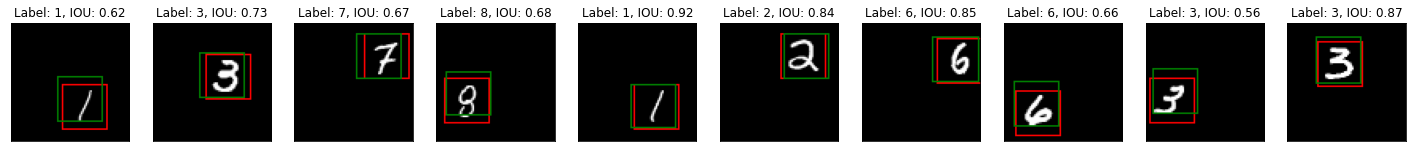

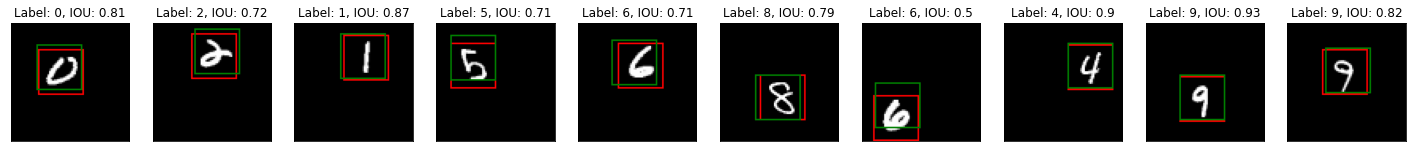

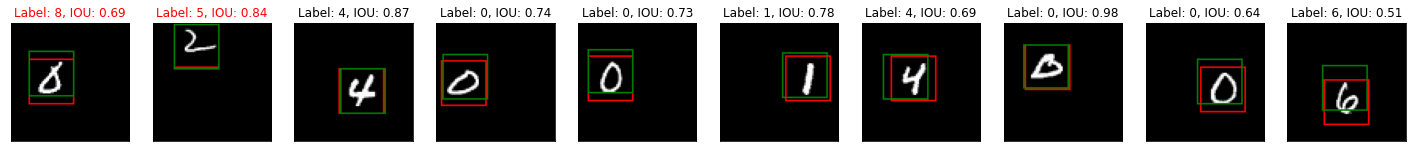

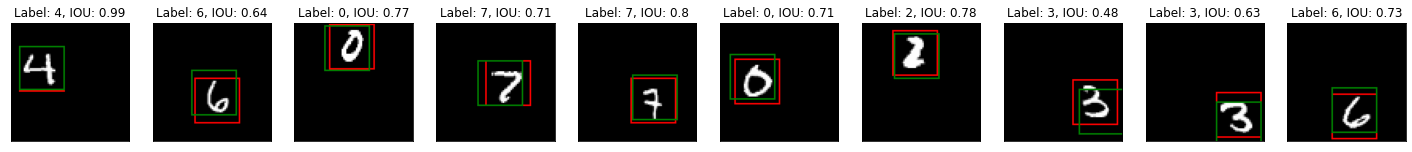

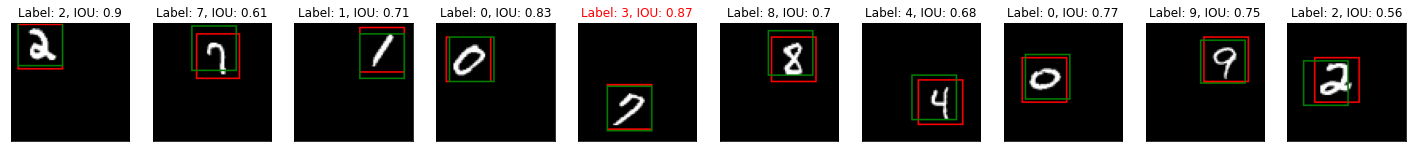

In [ ]:
import random
random_ids = random.sample(range(0, len(X_test)), 50)

best_model = tf.keras.models.clone_model(model, input_tensors=None, clone_function=None)
best_model.load_weights("best_model.hdf5")

for ids in batch(random_ids, 10):
    N = 10
    fig, ax = plt.subplots(nrows=1, ncols=N, figsize=(25, 10))
    for i, id in enumerate(ids):
        pred = best_model.predict(X_test[id].reshape(1, 75, 75, 1))
        pred_digit = class_names[np.argmax(pred[0])]
        pred_box = pred[1][0].tolist()

        true_digit = y1_test[id]
        true_box = y2_test[id]

        iou = intersection_over_union(pred_box, true_box)

        visualize_image(
            ax=ax[i],
            image=X_test[id], 
            true_box=true_box, 
            true_digit=true_digit,
            pred_box=pred_box,
            pred_digit=pred_digit,
            iou=float("{:.2f}".format(iou))
        )

plt.show()